In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

[SimpleMLP] Test RMSE: 0.606
[DeepMLP] Test RMSE: 0.577
[WideMLP] Test RMSE: 0.561


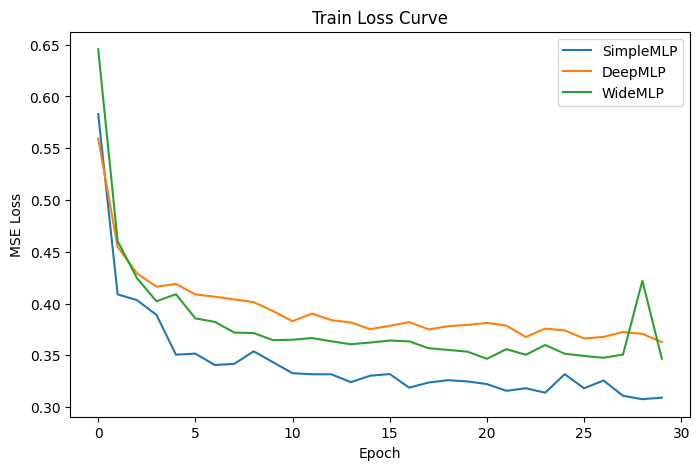

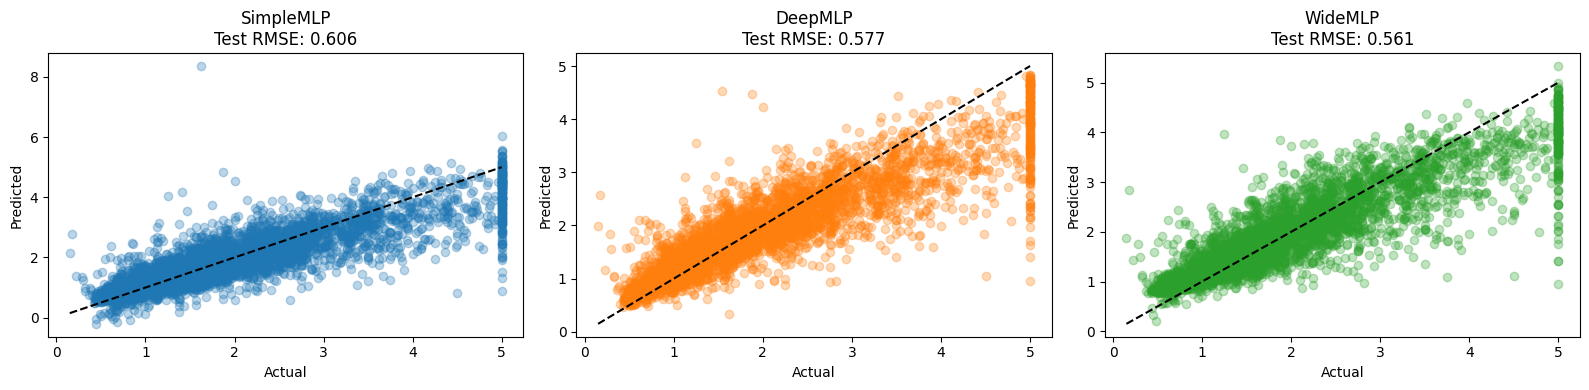

In [1]:
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
data = fetch_california_housing()
X = StandardScaler().fit_transform(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# 다양한 회귀 모델
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

class WideMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

models = [
    SimpleMLP(X_train.shape[1]),
    DeepMLP(X_train.shape[1]),
    WideMLP(X_train.shape[1])
]
model_names = ['SimpleMLP', 'DeepMLP', 'WideMLP']
colors = ['tab:blue', 'tab:orange', 'tab:green']
optimizers = [
    torch.optim.Adam(models[0].parameters(), lr=0.01),
    torch.optim.AdamW(models[1].parameters(), lr=0.005),
    torch.optim.RMSprop(models[2].parameters(), lr=0.01)
]

criterion = nn.MSELoss()
loss_histories = []
rmse_list = []
pred_list = []

# 모델별 학습 및 평가
for i, (model, opt, name) in enumerate(zip(models, optimizers, model_names)):
    losses = []
    for epoch in range(30):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            opt.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())
        losses.append(np.mean(batch_losses))
    loss_histories.append(losses)

    # 테스트 성능 및 예측값 저장
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).numpy().flatten()
        pred_list.append(y_pred)
        rmse = ((y_pred - y_test)**2).mean()**0.5
        rmse_list.append(rmse)
        print(f"[{name}] Test RMSE: {rmse:.3f}")

# 1. 학습 손실 곡선 비교
plt.figure(figsize=(8,5))
for i, name in enumerate(model_names):
    plt.plot(loss_histories[i], label=name, color=colors[i])
plt.title('Train Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 2. 테스트 예측값 vs 실제값 산점도
plt.figure(figsize=(16,4))
for i, name in enumerate(model_names):
    plt.subplot(1,3,i+1)
    plt.scatter(y_test, pred_list[i], alpha=0.3, color=colors[i])
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name}\nTest RMSE: {rmse_list[i]:.3f}')
plt.tight_layout()
plt.show()
